<h3>Creating the DataLoader</h3>

In [1]:
import os
import torch
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import sys
import argparse
from utils.aggregate_block.bd_attack_generate import bd_attack_img_trans_generate, bd_attack_label_trans_generate
from copy import deepcopy
from attack.badnet import BadNet
import warnings
warnings.filterwarnings('ignore')

2026-02-25:21:34:32 [INFO    ] [prototype.py:124] {'amp': False,
 'attack': 'badnet',
 'attack_label_trans': 'all2one',
 'attack_target': 0,
 'batch_size': 128,
 'bd_yaml_path': './config/attack/badnet/default.yaml',
 'client_optimizer': 'sgd',
 'dataset': 'cifar10',
 'dataset_path': './data/cifar10',
 'device': 'cuda:0',
 'epochs': 100,
 'frequency_save': 0,
 'img_size': (32, 32, 3),
 'input_channel': 3,
 'input_height': 32,
 'input_width': 32,
 'lr': 0.01,
 'lr_scheduler': 'CosineAnnealingLR',
 'model': 'preactresnet18',
 'non_blocking': True,
 'num_classes': 10,
 'num_workers': 4,
 'patch_mask_path': './resource/badnet/trigger_image.png',
 'pin_memory': True,
 'pratio': 0.1,
 'prefetch': False,
 'random_seed': 0,
 'save_folder_name': 'loader',
 'save_path': './record/loader',
 'sgd_momentum': 0.9,
 'terminal_info': ['C:\\Users\\Morris\\AppData\\Roaming\\Python\\Python311\\site-packages\\ipykernel_launcher.py',
                   '--f=c:\\Users\\Morris\\AppData\\Roaming\\jupyter\\run

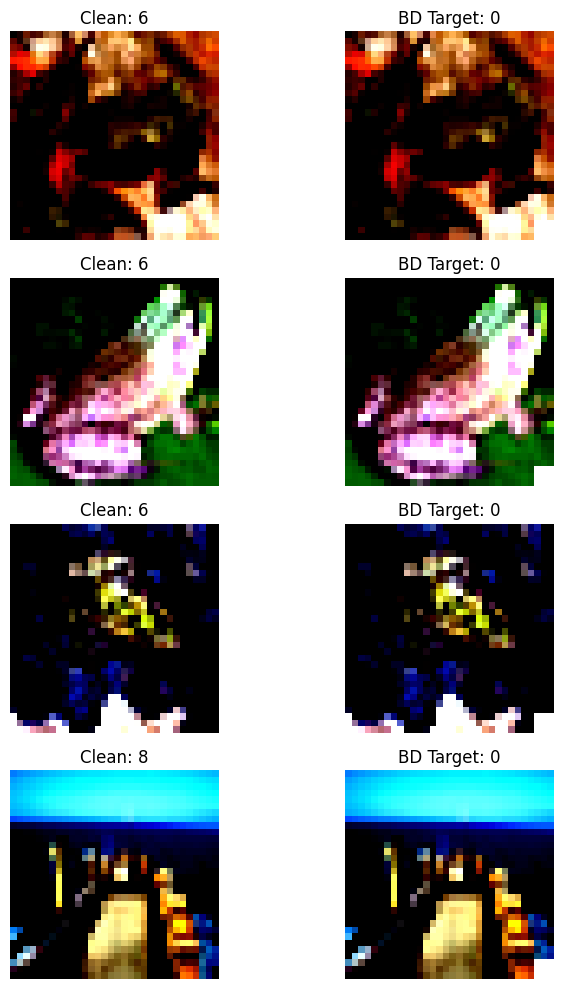

In [2]:
sys.path = ["./"] + sys.path

# Initialise BadNet attack instance
attack = BadNet()
parser = argparse.ArgumentParser()
parser = attack.set_args(parser)
parser = attack.set_bd_args(parser)
args = parser.parse_args(["--dataset", "cifar10", "--attack", "badnet", "--save_folder_name", "loader"])
attack.add_bd_yaml_to_args(args)
attack.add_yaml_to_args(args)
args = attack.process_args(args)
attack.prepare(args)
attack.stage1_non_training_data_prepare()


# 4-output data loader - used to output clean image/label and poisoned image/label
class ViTAnalysisTestDataset(torch.utils.data.Dataset):
    def __init__(self, raw_dataset, bd_img_trans, bd_lbl_trans, clean_trans):
        self.raw_dataset = raw_dataset  # raw test data
        self.bd_img_trans = bd_img_trans  # add backdoor patch
        self.bd_lbl_trans = bd_lbl_trans  # all2one attack
        self.clean_trans = clean_trans  # test image transforms.Compose (e.g. normalisation)

    def __getitem__(self, index):
        # Get raw image
        img_raw, label_clean = self.raw_dataset[index]
        
        # Create backdoor version of image and label
        img_bd_raw = self.bd_img_trans(deepcopy(img_raw))
        label_bd = self.bd_lbl_trans(label_clean)
        
        # Apply same transform on both clean and backdoor test data (ViTs need normalization from test_img_transform)
        img_clean_tensor = self.clean_trans(img_raw)
        img_bd_tensor = self.clean_trans(img_bd_raw)
        
        return img_clean_tensor, label_clean, img_bd_tensor, label_bd

    def __len__(self):
        return len(self.raw_dataset)


# BadNet-style attack preparation
(
    train_dataset_without_transform,  # raw train dataset without augmentation loaded directly from torchvision
    train_img_transform,  # torchvision.transforms composition (e.g. Resize, Normalize, ToTensor, Crop, Horizontal Flip)
    train_label_transform,  # No transform on label
    test_dataset_without_transform,  # raw test dataset without augmentation loaded directly from torchvision
    test_img_transform,  # torchvision.transforms composition (e.g. Resize, ToTensor)
    test_label_transform,  # No transform on label
    *others  # Discard the others as they are wrappers
) = attack.benign_prepare()


# Get the specific backdoor transformation logic
_, test_bd_img_transform = bd_attack_img_trans_generate(args) # add backdoor patch
bd_label_transform = bd_attack_label_trans_generate(args) # all2one attack


analysis_dataset = ViTAnalysisTestDataset(
    raw_dataset=test_dataset_without_transform,  # raw test dataset without augmentation loaded directly from torchvision
    bd_img_trans=test_bd_img_transform,  # add backdoor patch
    bd_lbl_trans=bd_label_transform,  # all2one attack
    clean_trans=test_img_transform  # test image transforms.Compose
)
analysis_loader = DataLoader(analysis_dataset, batch_size=4, shuffle=True)


# Plot clean and backdoor images and labels
def plot_vits_data(loader):
    img_c, lbl_c, img_b, lbl_b = next(iter(loader))
    
    fig, axes = plt.subplots(len(img_c), 2, figsize=(8, 10))
    for i in range(len(img_c)):
        # Display clean image and label
        axes[i, 0].imshow(img_c[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title(f"Clean: {lbl_c[i]}")
        axes[i, 0].axis('off')
        
        # Display backdoored image and label
        axes[i, 1].imshow(img_b[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title(f"BD Target: {lbl_b[i]}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


plot_vits_data(analysis_loader)

<h3>Training ViT Models from Scratch - Attacker's Perspective</h3>

In [2]:
def train_backdoor_variant(model_name, save_folder):
    # Initialise new BadNet instance
    attack = BadNet()
    parser = argparse.ArgumentParser()
    parser = attack.set_args(parser)
    parser = attack.set_bd_args(parser)
    
    # Configure for desired model
    args = parser.parse_args([
        "--dataset", "cifar10", 
        "--attack", "badnet", 
        "--model", model_name,
        # "--save_folder_name", save_folder,
        "--epochs", "200",
        "--num_workers", "0"
    ])
    
    # Process and run
    attack.add_bd_yaml_to_args(args)
    attack.add_yaml_to_args(args)
    args = attack.process_args(args)
    
    print(f"--- Starting Training: {model_name} ---")
    attack.prepare(args)
    attack.stage1_non_training_data_prepare()
    attack.stage2_training()
    print(f"--- Finished: {model_name} ---")

In [ ]:
train_backdoor_variant("vit_custom_tiny_p4", "vit_p4_experiment")

In [3]:
train_backdoor_variant("vit_custom_standard_p4", "vit_custom_standard_p4_experiment")

2026-02-25:20:20:54 [INFO    ] [prototype.py:124] {'amp': False,
 'attack': 'badnet',
 'attack_label_trans': 'all2one',
 'attack_target': 0,
 'batch_size': 128,
 'bd_yaml_path': './config/attack/badnet/default.yaml',
 'client_optimizer': 'sgd',
 'dataset': 'cifar10',
 'dataset_path': './data/cifar10',
 'device': 'cuda:0',
 'epochs': 200,
 'frequency_save': 0,
 'img_size': (32, 32, 3),
 'input_channel': 3,
 'input_height': 32,
 'input_width': 32,
 'lr': 0.01,
 'lr_scheduler': 'CosineAnnealingLR',
 'model': 'vit_custom_standard_p4',
 'non_blocking': True,
 'num_classes': 10,
 'num_workers': 0,
 'patch_mask_path': './resource/badnet/trigger_image.png',
 'pin_memory': True,
 'pratio': 0.1,
 'prefetch': False,
 'random_seed': 0,
 'save_path': './record/20260225_202054_ipykernel_launcher_attack_badnet_lruo',
 'sgd_momentum': 0.9,
 'terminal_info': ['C:\\Users\\Morris\\AppData\\Roaming\\Python\\Python311\\site-packages\\ipykernel_launcher.py',
                   '--f=c:\\Users\\Morris\\AppDat

--- Starting Training: vit_custom_standard_p4 ---


2026-02-25:20:20:56 [INFO    ] [backdoor_generate_poison_index.py:61] poison num:5000.0,real pratio:0.1
2026-02-25:20:20:56 [INFO    ] [bd_dataset_v2.py:133] save file format is .png
prepro_backdoor: 100%|██████████| 50000/50000 [00:02<00:00, 19529.53it/s]
2026-02-25:20:20:58 [INFO    ] [backdoor_generate_poison_index.py:61] poison num:9000.0,real pratio:0.9
2026-02-25:20:20:58 [INFO    ] [bd_dataset_v2.py:133] save file format is .png
prepro_backdoor: 100%|██████████| 10000/10000 [00:04<00:00, 2292.60it/s]
2026-02-25:20:21:03 [INFO    ] [badnet.py:193] stage2 start
2026-02-25:20:21:03 [INFO    ] [trainer_cls.py:972] Do NOT set the settings/parameters attr manually after you start training!
You may break the relationship between them.
2026-02-25:20:21:03 [INFO    ] [trainer_cls.py:1030] ('epoch_now:0, '
 'batch_now:0self.amp:False,self.criterion:CrossEntropyLoss(),self.optimizer:SGD '
 '(\n'
 'Parameter Group 0\n'
 '    dampening: 0\n'
 '    differentiable: False\n'
 '    foreach: None

--- Finished: vit_custom_standard_p4 ---


ACC (Clean Accuracy), ASR (Attack Success Rate)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

from models.vit_variants import ViT_Standard_P4, ViT_Tiny_P4

def evaluate_backdoor_performance(model, test_loader, device="cuda"):
    model.eval()
    model.to(device)
    
    total_samples = 0
    correct_clean = 0
    successful_attacks = 0
    
    print("--- Evaluating ACC and ASR ---")
    
    with torch.no_grad():
        # img_clean_tensor, label_clean, img_bd_tensor, label_bd
        for img_c, lbl_c, img_b, lbl_b in tqdm(test_loader):
            
            img_c, img_b = img_c.to(device), img_b.to(device)
            lbl_c, lbl_b = lbl_c.to(device), lbl_b.to(device)

            # Ensure labels are 1D integers (Batch Size,)
            lbl_c = lbl_c.view(-1).long()
            lbl_b = lbl_b.view(-1).long()

            # Test Clean Accuracy (ACC)
            outputs_c = model(img_c)
            _, preds_c = torch.max(outputs_c, 1)  # Find highest score across columns/classes
            correct_clean += (preds_c == lbl_c).sum().item()
            
            # Test Attack Success Rate (ASR)
            outputs_b = model(img_b)
            _, preds_b = torch.max(outputs_b, 1)
            successful_attacks += (preds_b == lbl_b).sum().item()
            
            total_samples += lbl_c.size(0)

    acc = (correct_clean / total_samples) * 100
    asr = (successful_attacks / total_samples) * 100
    
    print(f"\n[RESULTS]")
    print(f"Clean Accuracy (ACC): {acc:.2f}%")
    print(f"Attack Success Rate (ASR): {asr:.2f}%")
    
    return acc, asr

# Add safe globals for loading the model state dict
torch.serialization.add_safe_globals([
    np._core.multiarray.scalar, 
    np._core.multiarray._reconstruct,
    np.ndarray,
    np.dtype,
    np.dtypes.Int64DType,
    np.dtypes.Float64DType,
    np.dtypes.UInt32DType
])

# Load trained model state
# result = torch.load("./record/vit_tiny_p4_experiment/attack_result.pt")  # ACC: 68.76%, ASR: 92.39%
# model = ViT_Tiny_P4(num_classes=10)
# model.load_state_dict(result['model'])  # BackdoorBench wraps model parameters in a dict under the key 'model'

# result = torch.load("./record/vit_custom_standard_p4_experiment/attack_result.pt")  # ACC: 72.69%, ASR: 92.11%
# model = ViT_Standard_P4(num_classes=10)
# model.load_state_dict(result['model'])

result = torch.load("./record/20260225_202054_ipykernel_launcher_attack_badnet_lruo/attack_result.pt")  # ACC: 75.51%, ASR: 91.33%
model = ViT_Standard_P4(num_classes=10)
model.load_state_dict(result['model'])

# Run evaluation
evaluate_backdoor_performance(model, analysis_loader)

--- Evaluating ACC and ASR ---


100%|██████████| 2500/2500 [00:19<00:00, 126.83it/s]


[RESULTS]
Clean Accuracy (ACC): 75.51%
Attack Success Rate (ASR): 91.33%


(75.51, 91.33)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from einops import repeat

def perform_analysis(model, analysis_loader, device="cuda", num_batches=100):
    """
    Runs backdoor diagnostic tests on a trained model.
    1. Attention Heatmaps: Visualizes trigger focus
    2. Logit/Confidence: Measures model certainty
    3. CLS Norms: Checks feature magnitude
    4. t-SNE: Visualises class clustering
    5. Logit Lens: Internal decision path layer-by-layer
    6. Structural Probe: Rank/dimensionality analysis via SVD
    """
    model.eval().to(device)

    # CIFAR-10 Class Names with ID in brackets
    classes = ['Airplane (0)', 'Automobile (1)', 'Bird (2)', 'Cat (3)', 'Deer (4)', 
               'Dog (5)', 'Frog (6)', 'Horse (7)', 'Ship (8)', 'Truck (9)']
    
    all_cls_features = []
    clean_features_for_svd = []
    poison_features_for_svd = []
    all_labels = []
    all_confidences = []
    all_norms = []
    is_poisoned_list = [] # Tracker for t-SNE coloring

    print("--- Starting Analysis ---")

    # Iterate through batches to collect sample data for t-SNE
    with torch.no_grad():
        for i, (img_c, lbl_c, img_b, lbl_b) in enumerate(analysis_loader):
            if i >= num_batches: break
            
            img_c, img_b = img_c.to(device), img_b.to(device)
            lbl_c, lbl_b = lbl_c.to(device), lbl_b.to(device)

            # Get image predictions
            preds_c = torch.argmax(model(img_c), dim=1)
            preds_b = torch.argmax(model(img_b), dim=1)
            
            # Mask: (clean image is correct) AND (poisoned image hits target)
            effective_mask = (preds_c == lbl_c) & (preds_b == lbl_b)
            
            num_effective = effective_mask.sum().item()
            if num_effective == 0: continue
            
            # Filter dataset for effective pairs only (clean and target labels are predicted correctly)
            img_c, lbl_c = img_c[effective_mask], lbl_c[effective_mask]
            img_b, lbl_b = img_b[effective_mask], lbl_b[effective_mask]

            # Extract internal activations (manual forward pass through trained model)
            # Process clean and poisoned separately to compare
            for images, labels, poisoned_status in [(img_c, lbl_c, False), (img_b, lbl_b, True)]:

                # Logit lens (first sample of first batch)
                if i == 0:
                    run_logit_lens(model, images[0], device, f"Logit Lens: {'Poisoned' if poisoned_status else 'Clean'}")

                # Patching and embedding
                x = model.to_patch_embedding(images)
                b, n, _ = x.shape
                cls_tokens = torch.repeat_interleave(model.cls_token, b, dim=0)
                x = torch.cat((cls_tokens, x), dim=1)
                x += model.pos_embedding[:, :(n + 1)]

                # Transformer blocks
                for idx, block in enumerate(model.transformer):
                    x_norm = block.norm1(x)
                    # Extract attention weights from last layer
                    if idx == len(model.transformer) - 1:
                        _, attn_weights = block.attn(x_norm, x_norm, x_norm, need_weights=True)
                        last_attn = attn_weights 
                    
                    attn_out, _ = block.attn(x_norm, x_norm, x_norm)
                    x = x + attn_out
                    x = x + block.mlp(block.norm2(x))

                # Extract CLS token (index 0)
                cls_output = x[:, 0] # Shape: [batch, dim]
                logits = model.mlp_head(cls_output)
                probs = F.softmax(logits, dim=1)
                conf, _ = torch.max(probs, dim=1)

                # Store data
                feat_np = cls_output.cpu().numpy()
                all_cls_features.append(feat_np)
                
                if poisoned_status:
                    poison_features_for_svd.append(feat_np)
                    # For poisoned, label as the target class in the legend
                    all_labels.extend([f"Poisoned -> {classes[l]}" for l in labels.cpu().numpy()])
                else:
                    clean_features_for_svd.append(feat_np)
                    all_labels.extend([classes[l] for l in labels.cpu().numpy()])
                    
                all_confidences.extend(conf.cpu().numpy())
                all_norms.extend(torch.norm(cls_output, p=2, dim=1).cpu().numpy())

                # Use strings for legend clarity
                is_poisoned_list.extend(["Poisoned (ASR)" if poisoned_status else "Clean (ACC)"] * b)

                # Attention visualisation for first sample
                if i == 0:
                    plot_attention_on_image(images[0], last_attn[0], f"{'Poisoned' if poisoned_status else 'Clean'} Attention")

    # Logit and norm analysis summary
    analyze_metrics(all_confidences, all_norms, [p == "Poisoned (ASR)" for p in is_poisoned_list])

    # Run structural probe (SVD)
    run_structural_probe(np.vstack(clean_features_for_svd), np.vstack(poison_features_for_svd))

    # Feature space (t-SNE)
    run_tsne(np.vstack(all_cls_features), np.array(all_labels), np.array(is_poisoned_list))

def run_structural_probe(feats_clean, feats_poisoned):
    """
    Identifies the dimensionality of the backdoor.
    If poisoned energy is much steeper than clean, the backdoor is low-rank.
    """
    # Center the data
    X_c = feats_clean - feats_clean.mean(0)
    X_p = feats_poisoned - feats_poisoned.mean(0)

    # Perform SVD
    _, S_c, _ = torch.linalg.svd(torch.tensor(X_c), full_matrices=False)
    _, S_p, _ = torch.linalg.svd(torch.tensor(X_p), full_matrices=False)

    # Calculate cumulative energy
    energy_c = torch.cumsum(S_c**2, dim=0) / torch.sum(S_c**2)
    energy_p = torch.cumsum(S_p**2, dim=0) / torch.sum(S_p**2)

    plt.figure(figsize=(8, 5))
    plt.plot(energy_c[:30].numpy(), label="Clean Features", marker='o')
    plt.plot(energy_p[:30].numpy(), label="Poisoned Features", marker='x')
    plt.title("Structural Probe: Explained Variance by Component")
    plt.ylabel("Cumulative Energy (Variance)")
    plt.xlabel("Principal Component Index")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def run_logit_lens(model, img_tensor, device, title):
    """
    Visualises the model's belief at each layer.
    """
    img_tensor = img_tensor.unsqueeze(0).to(device)
    layer_probs = []
    
    with torch.no_grad():
        x = model.to_patch_embedding(img_tensor)
        b, n, _ = x.shape
        cls_tokens = repeat(model.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += model.pos_embedding[:, :(n + 1)]
        
        for block in model.transformer:
            x = block(x)
            # Apply the final classification head to the intermediate CLS token
            intermediate_logits = model.mlp_head(x[:, 0])
            layer_probs.append(torch.softmax(intermediate_logits, dim=-1).cpu().numpy())
    
    probs_array = np.array(layer_probs).squeeze() # [layers, classes]
    
    plt.figure(figsize=(10, 4))
    sns.heatmap(probs_array.T, cmap="viridis", annot=False)
    plt.title(title)
    plt.xlabel("Transformer Layer")
    plt.ylabel("Class ID")
    plt.show()

def plot_attention_on_image(img_tensor, attn_weights, title):
    """
    Overlays attention heatmap on the input image to see trigger focus.
    """
    # attn_weights shape: [Tokens, Tokens] (e.g. 65x65 for 4x4 patches on 32x32 image)
    # CLS token is at index 0. We want its attention to all other patches.
    cls_to_patches = attn_weights[0, 1:].cpu().numpy()
    side = int(np.sqrt(len(cls_to_patches)))
    heatmap = cls_to_patches.reshape(side, side)
    
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min()) # Normalize for display

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[1].imshow(heatmap, cmap='hot')
    ax[1].set_title(title)
    plt.show()

def analyze_metrics(confs, norms, is_bd):
    """
    Compares prediction confidence and CLS norms between clean and poisoned.
    """
    confs, norms, is_bd = np.array(confs), np.array(norms), np.array(is_bd)
    print(f"\n[CONFIDENCE ANALYSIS]")
    print(f"Clean Mean Confidence: {confs[~is_bd].mean():.4f}")
    print(f"Poison Mean Confidence: {confs[is_bd].mean():.4f} (High = Overfit to trigger)")
    
    print(f"\n[CLS TOKEN NORM ANALYSIS]")
    print(f"Clean Mean Norm: {norms[~is_bd].mean():.4f}")
    print(f"Poison Mean Norm: {norms[is_bd].mean():.4f} (Difference indicates anomaly)")

def run_tsne(features, labels, style_list):
    """
    Project high-dimensional features into 2D to see if poisoned samples cluster separately.
    """
    n_samples = features.shape[0]
    adaptive_perplexity = min(30, n_samples - 1)
    
    if adaptive_perplexity < 1:
        print("Not enough samples for t-SNE.")
        return

    tsne = TSNE(n_components=2, random_state=42, perplexity=adaptive_perplexity)
    embeds = tsne.fit_transform(features)
    
    plt.figure(figsize=(12, 7))
    # 'hue' handles the colors (classes), 'style' handles the markers (O vs X)
    sns.scatterplot(
        x=embeds[:,0], y=embeds[:,1], 
        hue=labels, 
        style=style_list, 
        markers={"Clean (ACC)": "o", "Poisoned (ASR)": "X"},
        palette='tab20',
        s=100,
        alpha=0.8
    )
    plt.title(f"t-SNE of CLS Token Features")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Class & Status")
    plt.tight_layout()
    plt.show()


--- Starting Analysis ---


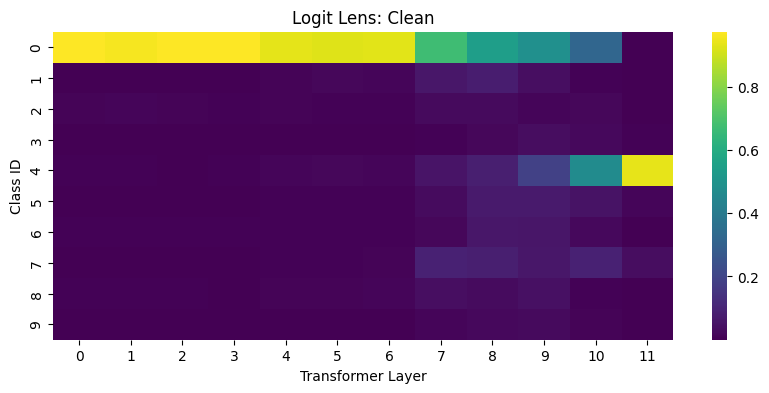

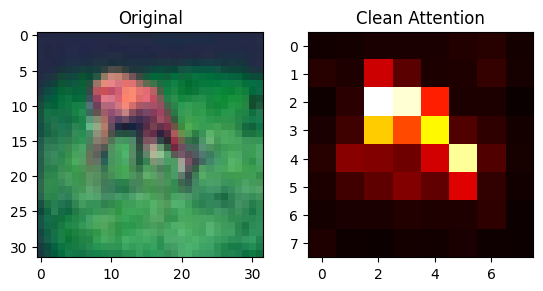

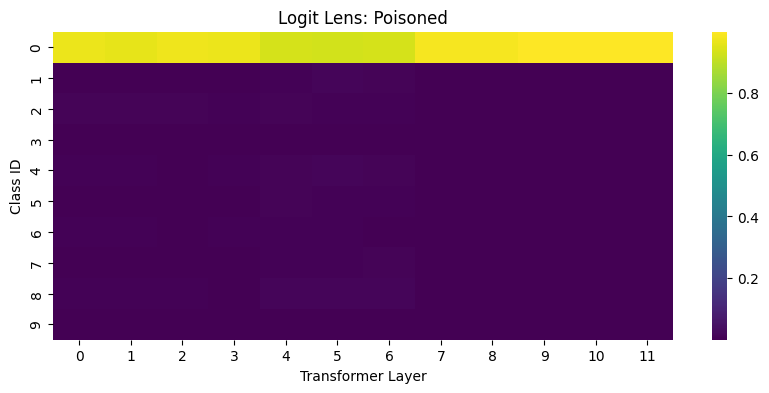

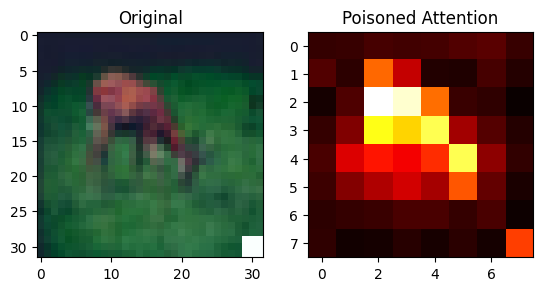


[CONFIDENCE ANALYSIS]
Clean Mean Confidence: 0.9019
Poison Mean Confidence: 0.9918 (High = Overfit to trigger)

[CLS TOKEN NORM ANALYSIS]
Clean Mean Norm: 4.3912
Poison Mean Norm: 7.6287 (Difference indicates anomaly)


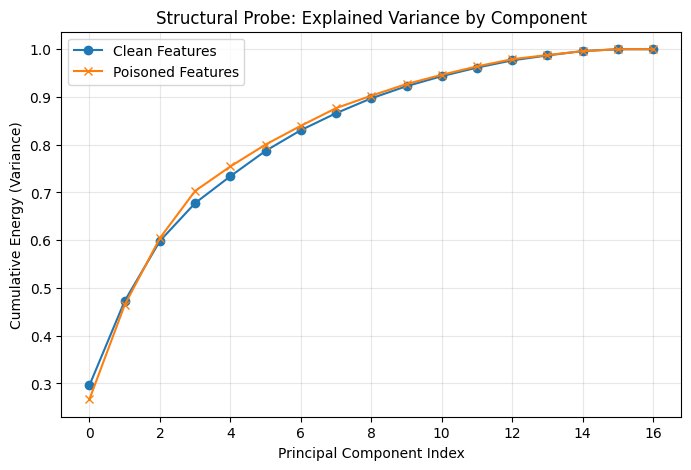

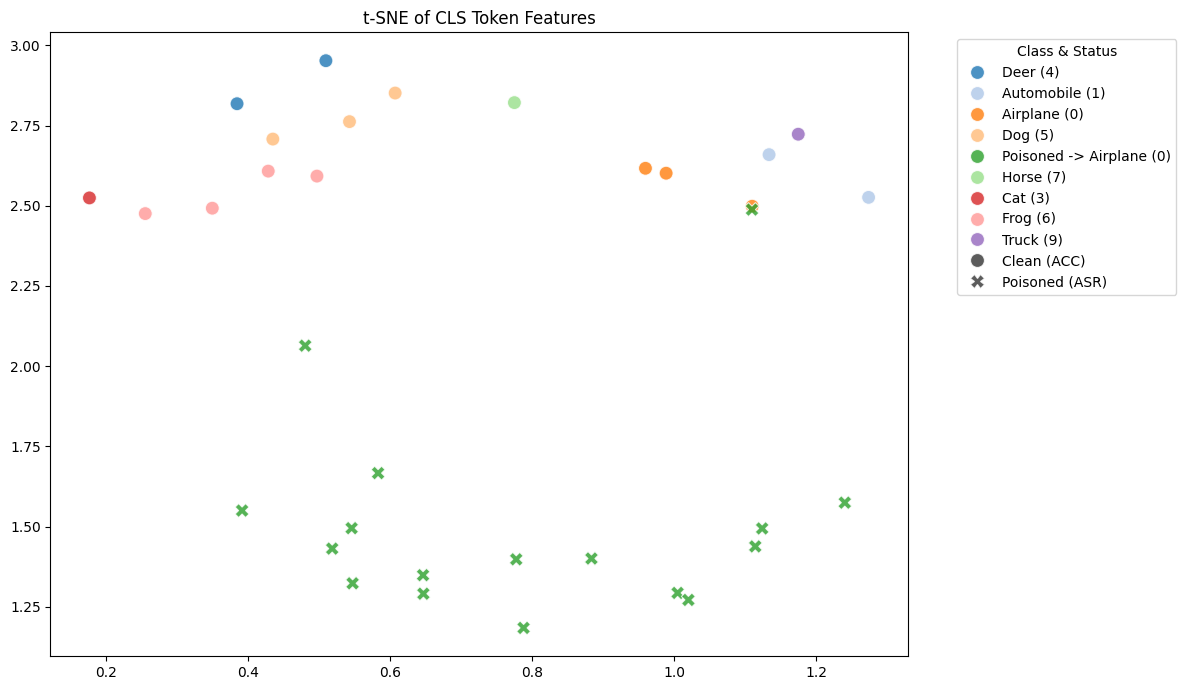

In [47]:
perform_analysis(model, analysis_loader, device="cuda", num_batches=5)